# **Image Denoising Using Convolutional Neural Networks:**
During the process of acquiring or transmitting the images, noise could be introduced to the images. Getting rid of this noise to recover the original image is called denoising. In many applications like medical image analysis, video survelliance and biometrics, it is essential to remove the noise, so that techniques like image parsing and object detection can be implemented accurately. 
In recent years, deep neural networks (DNN) have gained a lot of attention due to their success in denoising images. They don't require manual setting of parameters or complicated optimization procedures like their conventional counterparts do. The convolutional neural networks (CNNs) are the dominating type of DNN used in image denoising. [1] The success of CNNs stem from the fact that they employ regression rather than density estimation like conventional methods (Markov random fields and conditional random field). Regression allows models to have greater representational power than methods based on density estimation.

**Structure of a Convolutional Neural Network:** 

A CNN has three parts; input, hidden and output layers. These layers perform an alternating sequence of linear filtering and nonlinear transformation operations. Input and output layers include images, while hidden layers contain hidden units with images called feature maps that are the internal computations of the algorithm. Each feature map is created with the results of the previous feature map or the input image if it is the first iteration. The previous feature map is convolved with the adjusted weights, the results obtained from all perceptrons are summed. A bias parameter is subtracted from this sum and this result is passed through a sigmoid function (f(x) = 1/(1+exp(-x))). Finally, we obtain the next feature map. This newly obtained feature map is compared to the original image and a loss function is obtained. We would like to minimize this loss function to obtain an image as close to the original image as possible. So, we take partial derivatives of this function with respect to each weight and equate each equation to zero to solve for weights. These results become our new set of weights. With these adjusted weights we repeat the process above. When this forward and backward iterations are performed enough times, our noisy image should start looking like the original image. [2]         
**Project Specifications:**

Although CNNs can be used in other forms to denoise an image (like in blind denoising), in this project we will use them as a supervised learning method, meaning original images along with noised images will be used. We will build a four layer CNN. Layer's widths will be 8, 16, 8 and 4, respectively. Each layer will use a 3x3 kernel for filtering. No padding will be added in layers, meaning the output volume size after the layer will be the same as the input volume size. The model will be trained using the dataset from the tutorial. All images in batches of 8 images will be propagated through the network. Once this is completed an epoch is performed. We will perform 200 epochs. For each batch, we create denoised images, calculate the loss function as the mean squared error between them and the original images. Then, calculate the partial derivatives of the loss with respect to weights and adjust the neural network with the adjusted weights. At every 50 epoch, we will output noised, original and denoised images.




In [1]:
import pandas as pd
import tensorflow as tf 
import numpy as np 
from matplotlib import pyplot as plt
import sys, time, imageio, h5py, skimage, os, shutil
from tensorflow.keras.layers import Conv2D, Input
from skimage.transform import resize


In [2]:
# overwrite anyway 
if os.path.isdir('dataset'): 
    shutil.rmtree('dataset')
os.mkdir('dataset') # to save temp output

!wget -O dataset/demo-dataset.h5 https://raw.githubusercontent.com/AIScienceTutorial/Denoising/main/dataset/demo-dataset.h5

--2023-02-08 02:55:57--  https://raw.githubusercontent.com/AIScienceTutorial/Denoising/main/dataset/demo-dataset.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71307264 (68M) [application/octet-stream]
Saving to: ‘dataset/demo-dataset.h5’

dataset/demo-datase 100%[===================>]  68.00M   306MB/s    in 0.2s    

2023-02-08 02:56:03 (306 MB/s) - ‘dataset/demo-dataset.h5’ saved [71307264/71307264]



In [3]:
with h5py.File('dataset/demo-dataset.h5', 'r') as h5fd:
    ns_img_train = h5fd['train_ns'][:]
    gt_img_train = h5fd['train_gt'][:]

    ns_img_test = h5fd['test_ns'][:]
    gt_img_test = h5fd['test_gt'][:]

ns_img_train.shape, gt_img_train.shape, ns_img_test.shape, gt_img_test.shape

((512, 128, 128), (512, 128, 128), (32, 128, 128), (32, 128, 128))

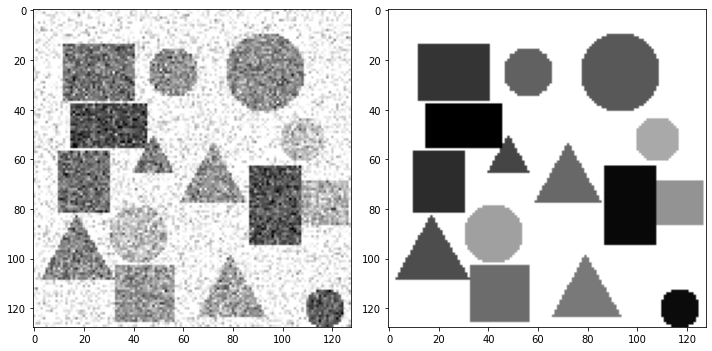

In [4]:
# visualize one of the pair
vis_idx = 0

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(ns_img_train[vis_idx], cmap='gray')
plt.subplot(122)
plt.imshow(gt_img_train[vis_idx], cmap='gray')
plt.tight_layout()
plt.show(); plt.close()

In [17]:
## function to create a CNN model
def cnn4dn_mdl(input_shape, layer_width=(8, 16, 8, 4)):
    inputs = Input(shape=input_shape)
    _tmp   = inputs
    for _lw in layer_width:
        _tmp = Conv2D(filters=_lw, kernel_size=3, padding='same', activation='relu')(_tmp)
        
    # output layer, 1 kernel/channel, no activation
    _out = Conv2D(filters=1, kernel_size=3, padding='same', activation=None)(_tmp)
    
    return tf.keras.models.Model(inputs, _out)

In [18]:
# create a model, 
# you can play with the width and depth of the CNN by editing layer_width

# Practice #1 try different model size
tf.keras.backend.clear_session()
dn_mdl = cnn4dn_mdl(input_shape=(None, None, 1), layer_width=(8, 16, 8, 4))
dn_mdl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 8)     80        
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 8)     1160      
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 4)     292       
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 1)     37        
                                                                 
Total params: 2,737
Trainable params: 2,737
Non-trainable par

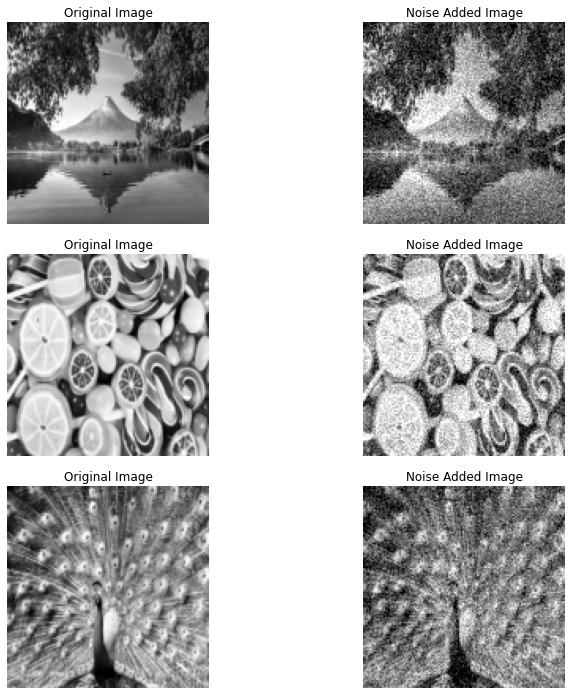

In [7]:
import skimage.io
import matplotlib.pyplot as plt
import skimage.filters
from skimage.util import random_noise 
#Adding noise to an image:
land = skimage.io.imread('land.jpg',as_gray=True)
land = resize(land[:,:], (128, 128))
candy = skimage.io.imread('candy.jpg',as_gray=True)
candy = resize(candy[:,:], (128, 128))
peacock = skimage.io.imread('peacock.jpg',as_gray=True)
peacock = resize(peacock[:,:], (128, 128))
#Add Gaussian noise:
noised_land = random_noise(land, mode='gaussian')
noised_candy = random_noise(candy, mode='gaussian')
noised_peacock = random_noise(peacock, mode='gaussian')
#Plot all noised images with the original image:
fig, ax = plt.subplots(nrows=3,ncols=2, figsize=(12,10), sharex=True, sharey=True, squeeze=True)
ax = ax.ravel()
ax[0].imshow(land, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(noised_land, cmap='gray')
ax[1].set_title('Noise Added Image')
ax[2].imshow(candy, cmap='gray')
ax[2].set_title('Original Image')
ax[3].imshow(noised_candy, cmap='gray')
ax[3].set_title('Noise Added Image')
ax[4].imshow(peacock,cmap='gray')
ax[4].set_title('Original Image')
ax[5].imshow(noised_peacock, cmap='gray')
ax[5].set_title('Noise Added Image')
fig.tight_layout()
for a in ax:
    a.axis('off')

4/4 [==============================] - 0s 3ms/step


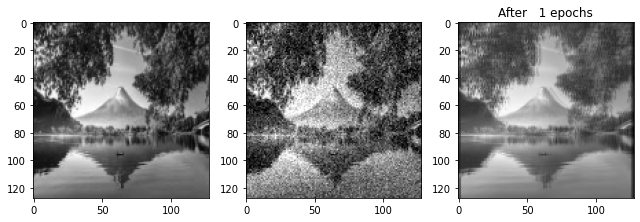

4/4 [==============================] - 0s 3ms/step


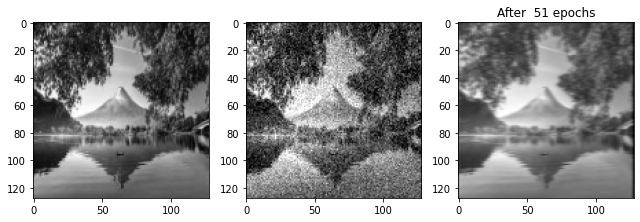

4/4 [==============================] - 0s 3ms/step


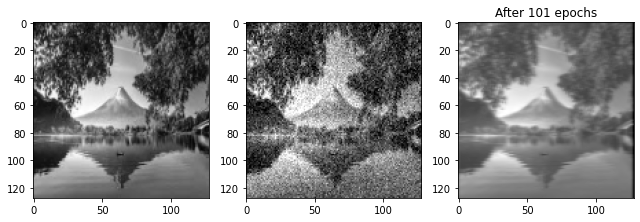

4/4 [==============================] - 0s 4ms/step


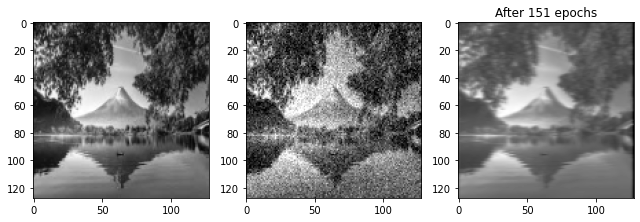

4/4 [==============================] - 0s 4ms/step


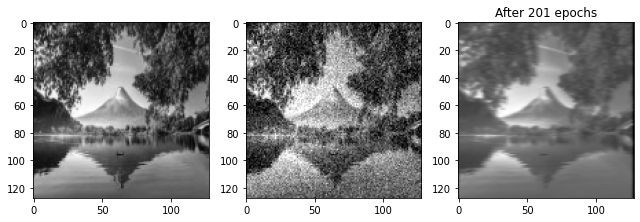

In [15]:
## let's start from scratch building a loop to train the model iteratively, as shown in the figure

mbsz = 8 # mini batch size

mdl_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

for epoch in range(201): # Practice #2 play with max epoches
    # iterate over sample pairs batch by batch
    for _sidx in range(0, ns_img_train.shape[0]-mbsz, mbsz): 
        
        # add an empty dimension to form 4D tensor
        mb_X = ns_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 
        mb_y = gt_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 

        with tf.GradientTape() as gd_tape:
            gd_tape.watch(dn_mdl.trainable_variables)
            
            dn_img = dn_mdl(mb_X, training=True) # try to denoise
            
            # compute the loss, use MSE here
            loss_mse = tf.losses.mean_squared_error(dn_img, mb_y)

            # compute the derivative of loss function of the model weights, i.e., gradient of weight
            gradients= gd_tape.gradient(loss_mse, dn_mdl.trainable_variables)
            
            # update neural network weights
            mdl_optimizer.apply_gradients(zip(gradients, dn_mdl.trainable_variables))

    if epoch % 50 != 0: continue # let's check how model performs after every 50 epochs 
    if epoch == 0:
        val_X, val_y = land[:,:,np.newaxis], noised_land
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    dn_img_val = dn_mdl.predict(val_X).squeeze()
    
    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.imshow(ns4vis, cmap='gray')
    plt.subplot(132)
    plt.imshow(gt4vis, cmap='gray')
    plt.subplot(133)
    plt.imshow(dn_img_val, cmap='gray')
    plt.title('After %3d epochs' % (epoch+1))
    plt.tight_layout(); plt.show(); plt.close()


4/4 [==============================] - 0s 3ms/step


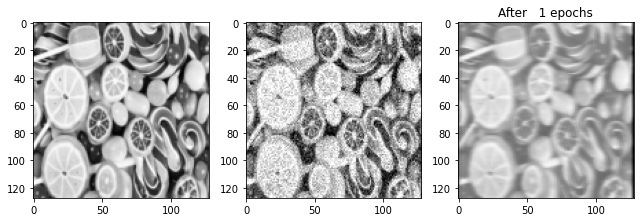

4/4 [==============================] - 0s 3ms/step


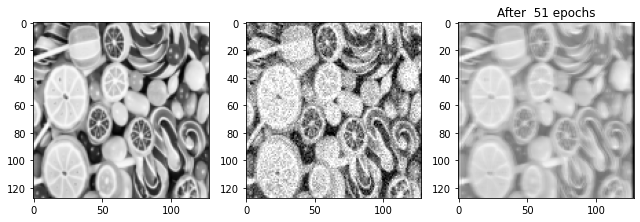

4/4 [==============================] - 0s 5ms/step


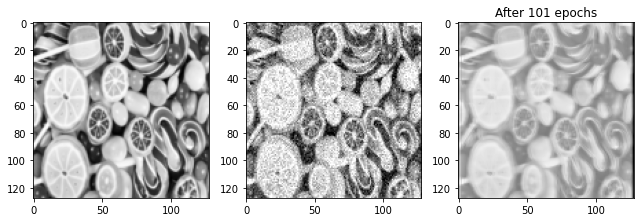

4/4 [==============================] - 0s 4ms/step


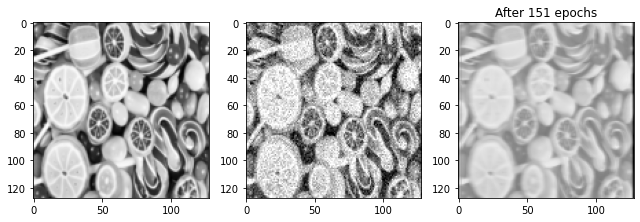

4/4 [==============================] - 0s 3ms/step


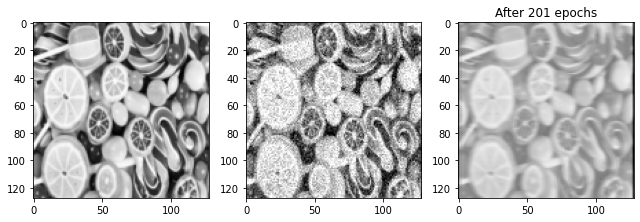

In [9]:
## let's start from scratch building a loop to train the model iteratively, as shown in the figure

mbsz = 8 # mini batch size

mdl_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

for epoch in range(201): # Practice #2 play with max epoches
    # iterate over sample pairs batch by batch
    for _sidx in range(0, ns_img_train.shape[0]-mbsz, mbsz): 
        
        # add an empty dimension to form 4D tensor
        mb_X = ns_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 
        mb_y = gt_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 

        with tf.GradientTape() as gd_tape:
            gd_tape.watch(dn_mdl.trainable_variables)
            
            dn_img = dn_mdl(mb_X, training=True) # try to denoise
            
            # compute the loss, use MSE here
            loss_mse = tf.losses.mean_squared_error(dn_img, mb_y)

            # compute the derivative of loss function of the model weights, i.e., gradient of weight
            gradients= gd_tape.gradient(loss_mse, dn_mdl.trainable_variables)
            
            # update neural network weights
            mdl_optimizer.apply_gradients(zip(gradients, dn_mdl.trainable_variables))

    if epoch % 50 != 0: continue # let's check how model performs after every 50 epochs 
    """
    if epoch == 0:
        val_X, val_y = ns_img_test[-1:,:,:,np.newaxis], gt_img_test[-1:]
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    """
    if epoch == 0:
        val_X, val_y = candy[:,:,np.newaxis], noised_candy
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    dn_img_val = dn_mdl.predict(val_X).squeeze()
    
    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.imshow(ns4vis, cmap='gray')
    plt.subplot(132)
    plt.imshow(gt4vis, cmap='gray')
    plt.subplot(133)
    plt.imshow(dn_img_val, cmap='gray')
    plt.title('After %3d epochs' % (epoch+1))
    plt.tight_layout(); plt.show(); plt.close()


4/4 [==============================] - 0s 3ms/step


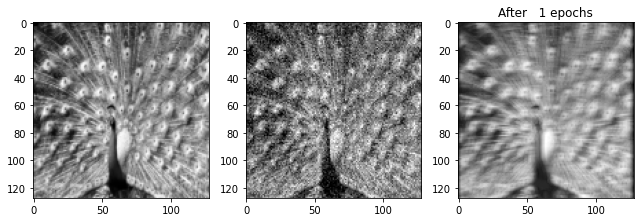

4/4 [==============================] - 0s 3ms/step


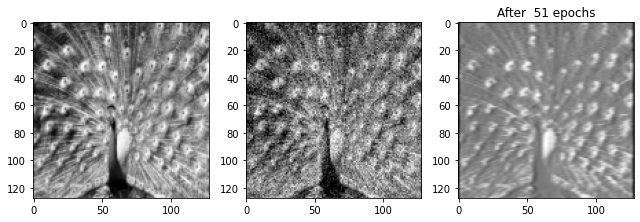

4/4 [==============================] - 0s 4ms/step


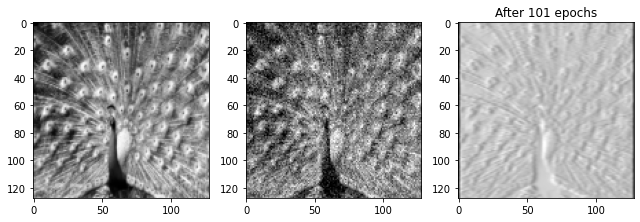

4/4 [==============================] - 0s 5ms/step


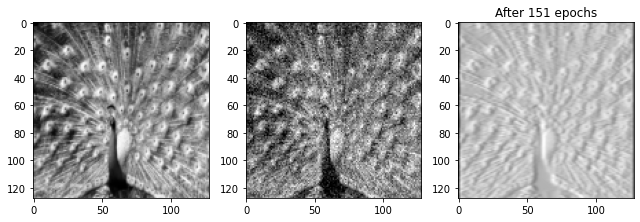

4/4 [==============================] - 0s 3ms/step


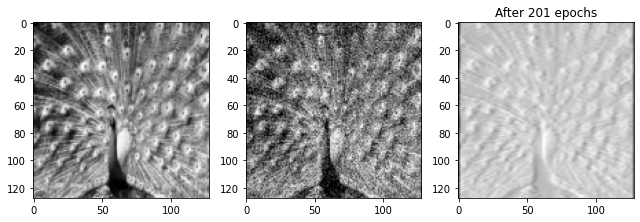

In [19]:
## let's start from scratch building a loop to train the model iteratively, as shown in the figure

mbsz = 8 # mini batch size

mdl_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

for epoch in range(201): # Practice #2 play with max epoches
    # iterate over sample pairs batch by batch
    for _sidx in range(0, ns_img_train.shape[0]-mbsz, mbsz): 
        
        # add an empty dimension to form 4D tensor
        mb_X = ns_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 
        mb_y = gt_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 

        with tf.GradientTape() as gd_tape:
            gd_tape.watch(dn_mdl.trainable_variables)
            
            dn_img = dn_mdl(mb_X, training=True) # try to denoise
            
            # compute the loss, use MSE here
            loss_mse = tf.losses.mean_squared_error(dn_img, mb_y)

            # compute the derivative of loss function of the model weights, i.e., gradient of weight
            gradients= gd_tape.gradient(loss_mse, dn_mdl.trainable_variables)
            
            # update neural network weights
            mdl_optimizer.apply_gradients(zip(gradients, dn_mdl.trainable_variables))

    if epoch % 50 != 0: continue # let's check how model performs after every 50 epochs 
    """
    if epoch == 0:
        val_X, val_y = ns_img_test[-1:,:,:,np.newaxis], gt_img_test[-1:]
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    """
    if epoch == 0:
        val_X, val_y = peacock[:,:,np.newaxis], noised_peacock
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    dn_img_val = dn_mdl.predict(val_X).squeeze()
    
    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.imshow(ns4vis, cmap='gray')
    plt.subplot(132)
    plt.imshow(gt4vis, cmap='gray')
    plt.subplot(133)
    plt.imshow(dn_img_val, cmap='gray')
    plt.title('After %3d epochs' % (epoch+1))
    plt.tight_layout(); plt.show(); plt.close()


In [21]:

tf.keras.backend.clear_session()
dn_mdl = cnn4dn_mdl(input_shape=(None, None, 1), layer_width=(8, 16, 8, 4))
dn_mdl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.mean_squared_error,
    # List of metrics to monitor
    metrics=[tf.keras.metrics.mean_absolute_error],
)


In [12]:
#dn_mdl.save("dn-mdl-toy.h5", include_optimizer=False)

In [22]:
val_noised =np.array([noised_land, noised_candy, noised_peacock])
val_gt = np.array([land, candy, peacock])

In [27]:

history = dn_mdl.fit(
    ns_img_train,
    gt_img_train,
    batch_size=8,
    epochs=10,
    validation_data=(val_noised, val_gt),
)

Epoch 1/10
64/64 [==============================] - 1s 9ms/step - loss: 6.8630e-04 - mean_absolute_error: 0.0132 - val_loss: 0.0105 - val_mean_absolute_error: 0.0772
Epoch 2/10
64/64 [==============================] - 0s 7ms/step - loss: 6.8315e-04 - mean_absolute_error: 0.0131 - val_loss: 0.0105 - val_mean_absolute_error: 0.0770
Epoch 3/10
64/64 [==============================] - 0s 7ms/step - loss: 6.8136e-04 - mean_absolute_error: 0.0131 - val_loss: 0.0107 - val_mean_absolute_error: 0.0779
Epoch 4/10
64/64 [==============================] - 0s 7ms/step - loss: 6.8064e-04 - mean_absolute_error: 0.0132 - val_loss: 0.0106 - val_mean_absolute_error: 0.0773
Epoch 5/10
64/64 [==============================] - 0s 7ms/step - loss: 6.8305e-04 - mean_absolute_error: 0.0134 - val_loss: 0.0106 - val_mean_absolute_error: 0.0773
Epoch 6/10
64/64 [==============================] - 0s 8ms/step - loss: 6.7561e-04 - mean_absolute_error: 0.0131 - val_loss: 0.0106 - val_mean_absolute_error: 0.0771
Epoc

**Analysis:**

 It seems like more and more features are retained at every 50 epoch. However, images have a very washed-out appearance and the "peacock" image seems especially blurry. 
 On the other hand, mean absolute error is around 0.013 and decreases after each epoch a little further as expected. Mean absolute error for our three images is around 0.077 which is expected as the size of the validation set is pretty small. 
We will try a CNN with five layers and batch size of 20 to see if there will be any changes.   

In [28]:

tf.keras.backend.clear_session()
dn_mdl = cnn4dn_mdl(input_shape=(None, None, 1), layer_width=(8, 16, 16, 8, 4))
dn_mdl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.mean_squared_error,
    # List of metrics to monitor
    metrics=[tf.keras.metrics.mean_absolute_error],
)

In [30]:

history = dn_mdl.fit(
    ns_img_train,
    gt_img_train,
    batch_size=8,
    epochs=20,
    validation_data=(val_noised, val_gt),
)

Epoch 1/20
64/64 [==============================] - 1s 14ms/step - loss: 0.0060 - mean_absolute_error: 0.0463 - val_loss: 0.0064 - val_mean_absolute_error: 0.0614
Epoch 2/20
64/64 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_absolute_error: 0.0447 - val_loss: 0.0062 - val_mean_absolute_error: 0.0606
Epoch 3/20
64/64 [==============================] - 1s 8ms/step - loss: 0.0054 - mean_absolute_error: 0.0433 - val_loss: 0.0063 - val_mean_absolute_error: 0.0609
Epoch 4/20
64/64 [==============================] - 1s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0421 - val_loss: 0.0062 - val_mean_absolute_error: 0.0606
Epoch 5/20
64/64 [==============================] - 1s 8ms/step - loss: 0.0044 - mean_absolute_error: 0.0405 - val_loss: 0.0060 - val_mean_absolute_error: 0.0602
Epoch 6/20
64/64 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0380 - val_loss: 0.0060 - val_mean_absolute_error: 0.0602
Epoch 7/20
64/64 [========

When we added another layer, mean absolute error (MAE) for the training went from 0.0129 to 0.0257 at the last epochs. For the validation, MAE went from 0.0783 to 0.0642 at the last epochs. So, we could say by adding another layer, we helped our model to generalize better and prevented overfitting.
Let's apply this model to our images:

4/4 [==============================] - 0s 5ms/step


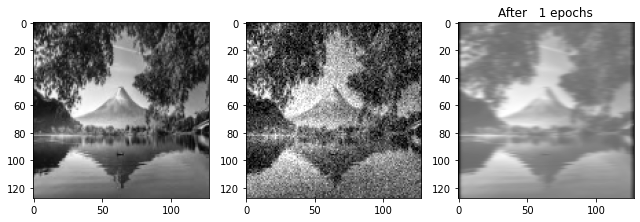

4/4 [==============================] - 0s 3ms/step


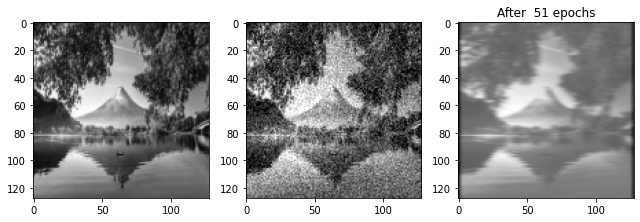

4/4 [==============================] - 0s 4ms/step


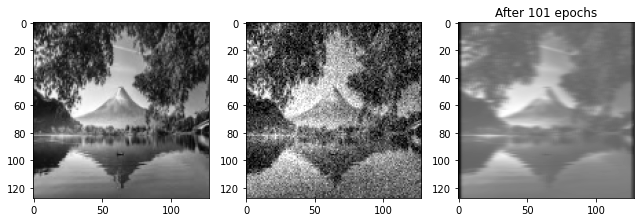

4/4 [==============================] - 0s 5ms/step


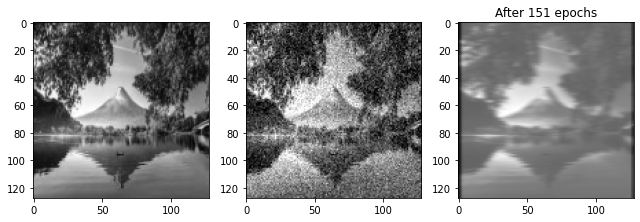

4/4 [==============================] - 0s 4ms/step


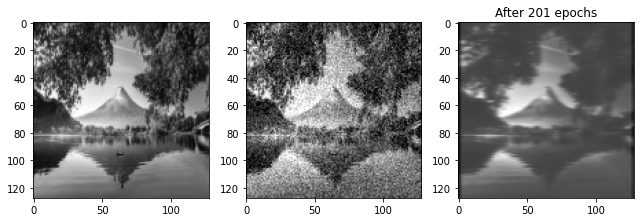

In [31]:
## let's start from scratch building a loop to train the model iteratively, as shown in the figure

mbsz = 8 # mini batch size

mdl_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

for epoch in range(201): # Practice #2 play with max epoches
    # iterate over sample pairs batch by batch
    for _sidx in range(0, ns_img_train.shape[0]-mbsz, mbsz): 
        
        # add an empty dimension to form 4D tensor
        mb_X = ns_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 
        mb_y = gt_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 

        with tf.GradientTape() as gd_tape:
            gd_tape.watch(dn_mdl.trainable_variables)
            
            dn_img = dn_mdl(mb_X, training=True) # try to denoise
            
            # compute the loss, use MSE here
            loss_mse = tf.losses.mean_squared_error(dn_img, mb_y)

            # compute the derivative of loss function of the model weights, i.e., gradient of weight
            gradients= gd_tape.gradient(loss_mse, dn_mdl.trainable_variables)
            
            # update neural network weights
            mdl_optimizer.apply_gradients(zip(gradients, dn_mdl.trainable_variables))

    if epoch % 50 != 0: continue # let's check how model performs after every 50 epochs 
    if epoch == 0:
        val_X, val_y = land[:,:,np.newaxis], noised_land
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    dn_img_val = dn_mdl.predict(val_X).squeeze()
    
    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.imshow(ns4vis, cmap='gray')
    plt.subplot(132)
    plt.imshow(gt4vis, cmap='gray')
    plt.subplot(133)
    plt.imshow(dn_img_val, cmap='gray')
    plt.title('After %3d epochs' % (epoch+1))
    plt.tight_layout(); plt.show(); plt.close()


4/4 [==============================] - 0s 5ms/step


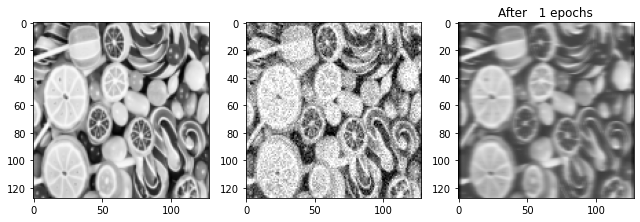

4/4 [==============================] - 0s 4ms/step


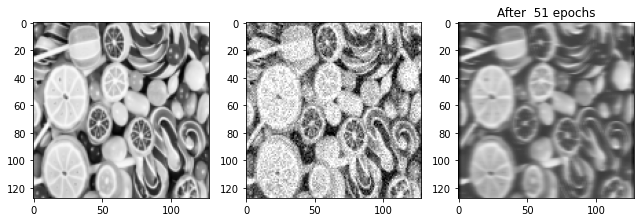

4/4 [==============================] - 0s 3ms/step


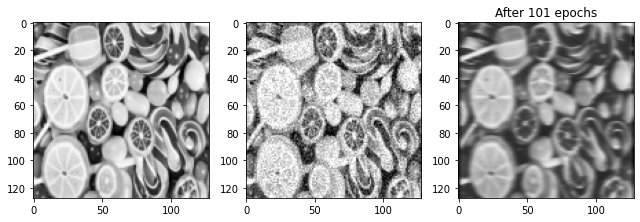

4/4 [==============================] - 0s 5ms/step


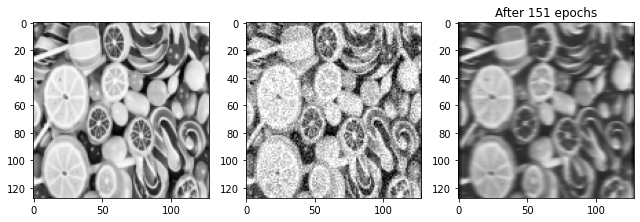

4/4 [==============================] - 0s 5ms/step


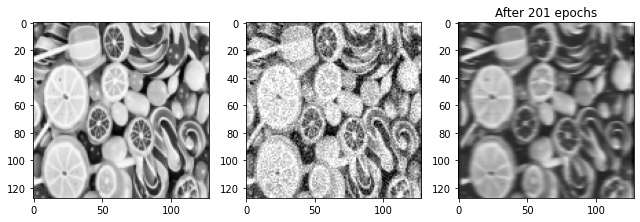

In [32]:
## let's start from scratch building a loop to train the model iteratively, as shown in the figure

mbsz = 8 # mini batch size

mdl_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

for epoch in range(201): # Practice #2 play with max epoches
    # iterate over sample pairs batch by batch
    for _sidx in range(0, ns_img_train.shape[0]-mbsz, mbsz): 
        
        # add an empty dimension to form 4D tensor
        mb_X = ns_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 
        mb_y = gt_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 

        with tf.GradientTape() as gd_tape:
            gd_tape.watch(dn_mdl.trainable_variables)
            
            dn_img = dn_mdl(mb_X, training=True) # try to denoise
            
            # compute the loss, use MSE here
            loss_mse = tf.losses.mean_squared_error(dn_img, mb_y)

            # compute the derivative of loss function of the model weights, i.e., gradient of weight
            gradients= gd_tape.gradient(loss_mse, dn_mdl.trainable_variables)
            
            # update neural network weights
            mdl_optimizer.apply_gradients(zip(gradients, dn_mdl.trainable_variables))

    if epoch % 50 != 0: continue # let's check how model performs after every 50 epochs 
    """
    if epoch == 0:
        val_X, val_y = ns_img_test[-1:,:,:,np.newaxis], gt_img_test[-1:]
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    """
    if epoch == 0:
        val_X, val_y = candy[:,:,np.newaxis], noised_candy
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    dn_img_val = dn_mdl.predict(val_X).squeeze()
    
    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.imshow(ns4vis, cmap='gray')
    plt.subplot(132)
    plt.imshow(gt4vis, cmap='gray')
    plt.subplot(133)
    plt.imshow(dn_img_val, cmap='gray')
    plt.title('After %3d epochs' % (epoch+1))
    plt.tight_layout(); plt.show(); plt.close()


4/4 [==============================] - 0s 3ms/step


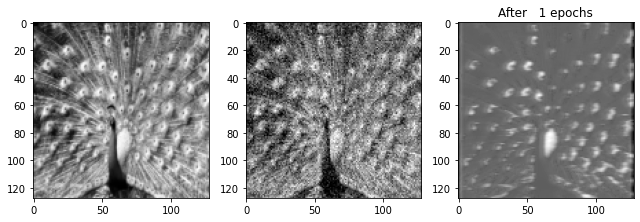

4/4 [==============================] - 0s 4ms/step


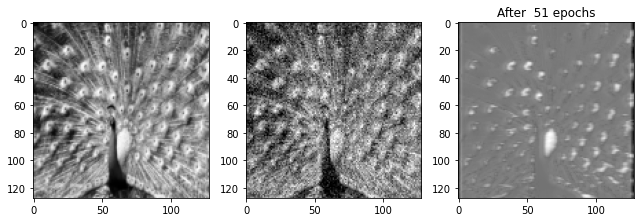

4/4 [==============================] - 0s 5ms/step


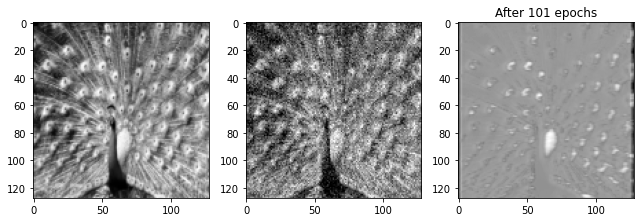

4/4 [==============================] - 0s 4ms/step


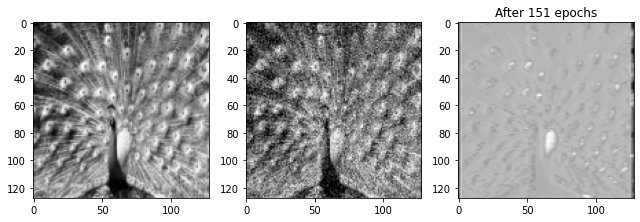

4/4 [==============================] - 0s 5ms/step


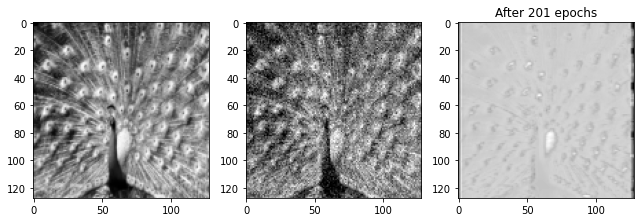

In [34]:
## let's start from scratch building a loop to train the model iteratively, as shown in the figure

mbsz = 8 # mini batch size

mdl_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

for epoch in range(201): # Practice #2 play with max epoches
    # iterate over sample pairs batch by batch
    for _sidx in range(0, ns_img_train.shape[0]-mbsz, mbsz): 
        
        # add an empty dimension to form 4D tensor
        mb_X = ns_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 
        mb_y = gt_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 

        with tf.GradientTape() as gd_tape:
            gd_tape.watch(dn_mdl.trainable_variables)
            
            dn_img = dn_mdl(mb_X, training=True) # try to denoise
            
            # compute the loss, use MSE here
            loss_mse = tf.losses.mean_squared_error(dn_img, mb_y)

            # compute the derivative of loss function of the model weights, i.e., gradient of weight
            gradients= gd_tape.gradient(loss_mse, dn_mdl.trainable_variables)
            
            # update neural network weights
            mdl_optimizer.apply_gradients(zip(gradients, dn_mdl.trainable_variables))

    if epoch % 50 != 0: continue # let's check how model performs after every 50 epochs 
    """
    if epoch == 0:
        val_X, val_y = ns_img_test[-1:,:,:,np.newaxis], gt_img_test[-1:]
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    """
    if epoch == 0:
        val_X, val_y = peacock[:,:,np.newaxis], noised_peacock
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    dn_img_val = dn_mdl.predict(val_X).squeeze()
    
    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.imshow(ns4vis, cmap='gray')
    plt.subplot(132)
    plt.imshow(gt4vis, cmap='gray')
    plt.subplot(133)
    plt.imshow(dn_img_val, cmap='gray')
    plt.title('After %3d epochs' % (epoch+1))
    plt.tight_layout(); plt.show(); plt.close()


By adding another layer, we have had success with land and candy images especially after the last epoch. They don't have a washed-out appearance any more. However peacock image looks much worse. In the following, we will drop layers to two to see if there will be an improvement.

In [36]:
tf.keras.backend.clear_session()
dn_mdl = cnn4dn_mdl(input_shape=(None, None, 1), layer_width=(8, 4))
dn_mdl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.mean_squared_error,
    # List of metrics to monitor
    metrics=[tf.keras.metrics.mean_absolute_error],
)

4/4 [==============================] - 0s 3ms/step


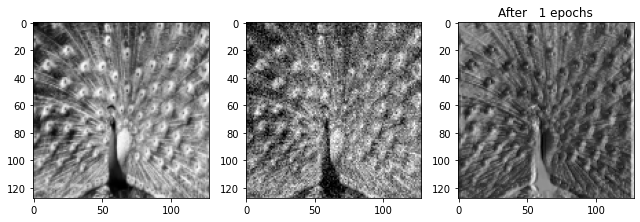

4/4 [==============================] - 0s 4ms/step


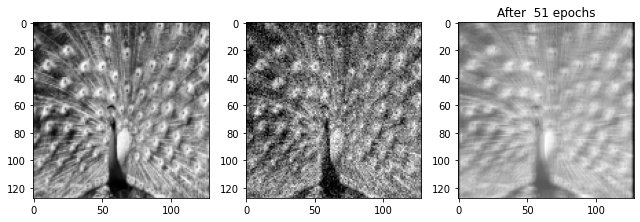

4/4 [==============================] - 0s 3ms/step


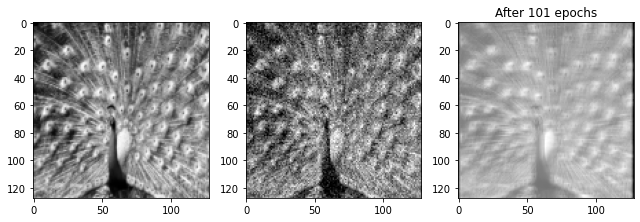

4/4 [==============================] - 0s 5ms/step


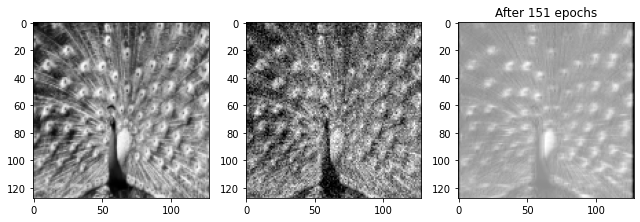

4/4 [==============================] - 0s 3ms/step


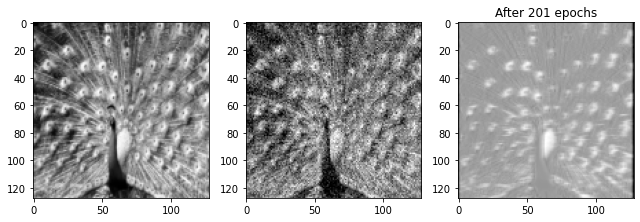

In [37]:
## let's start from scratch building a loop to train the model iteratively, as shown in the figure

mbsz = 8 # mini batch size

mdl_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

for epoch in range(201): # Practice #2 play with max epoches
    # iterate over sample pairs batch by batch
    for _sidx in range(0, ns_img_train.shape[0]-mbsz, mbsz): 
        
        # add an empty dimension to form 4D tensor
        mb_X = ns_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 
        mb_y = gt_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 

        with tf.GradientTape() as gd_tape:
            gd_tape.watch(dn_mdl.trainable_variables)
            
            dn_img = dn_mdl(mb_X, training=True) # try to denoise
            
            # compute the loss, use MSE here
            loss_mse = tf.losses.mean_squared_error(dn_img, mb_y)

            # compute the derivative of loss function of the model weights, i.e., gradient of weight
            gradients= gd_tape.gradient(loss_mse, dn_mdl.trainable_variables)
            
            # update neural network weights
            mdl_optimizer.apply_gradients(zip(gradients, dn_mdl.trainable_variables))

    if epoch % 50 != 0: continue # let's check how model performs after every 50 epochs 
    """
    if epoch == 0:
        val_X, val_y = ns_img_test[-1:,:,:,np.newaxis], gt_img_test[-1:]
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    """
    if epoch == 0:
        val_X, val_y = peacock[:,:,np.newaxis], noised_peacock
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    dn_img_val = dn_mdl.predict(val_X).squeeze()
    
    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.imshow(ns4vis, cmap='gray')
    plt.subplot(132)
    plt.imshow(gt4vis, cmap='gray')
    plt.subplot(133)
    plt.imshow(dn_img_val, cmap='gray')
    plt.title('After %3d epochs' % (epoch+1))
    plt.tight_layout(); plt.show(); plt.close()


It still doesn't look good, but much better than 4 and 5 layered network results. Maybe it is due to the fact that this image has patterns laid out all over the image and the CNN can't distiguish these patterns from the noise which is also uniformly spread out.

Reference:
[1]: https://ietresearch.onlinelibrary.wiley.com/doi/10.1049/ipr2.12748?af=R#ipr212748-bib-0011


[2]: Natural Image Denoising with Convolutional Networks 
https://proceedings.neurips.cc/paper/2008/file/c16a5320fa475530d9583c34fd356ef5-Paper.pdf

Peacock image: https://images.pexels.com/photos/638738/pexels-photo-638738.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1

Land image: https://helpx.adobe.com/photoshop/using/convert-color-image-black-white.html

Candy image: https://www.simplemost.com/wp-content/uploads/2015/09/candy.jpg
